<a href="https://colab.research.google.com/github/alexmrin/Image-deep-learning/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [204]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
import torch.optim as optim
import torchvision.utils as vutils
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **Settings**

In [205]:
def set_all_seeds(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Hyperparameters
batch_size = 64
lr = 0.0003
num_epochs = 30
random_seed = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#set_all_seeds(random_seed)
if device == 'cuda':
  current_seed = torch.cuda.initial_seed()
else:
  current_seed = torch.initial_seed()

if random_seed == current_seed: print('set seeds')
device

set seeds


'cuda'

In [206]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [207]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


dataset = CIFAR10(root='./data', train=True, transform=train_transform, download=True)
train_dataset, val_dataset = random_split(dataset=dataset, lengths=[0.9, 0.1])
test_dataset = CIFAR10(root='./data', train=False, transform=test_transform, download=False)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Files already downloaded and verified


### Model Architecture

In [208]:
class Resnet(nn.Module):
  def __init__(self):
    super().__init__()

    block16 = ResidualBlock(16)
    block16_d = ResidualBlock(16, downsample=True)
    block32 = ResidualBlock(32)

    block32_d = ResidualBlock(32, downsample=True)
    block64 = ResidualBlock(64)

    #input size is Bx3x32x32
    self.features = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=16),
        nn.ReLU(),

        block16,
        block16,
        block16,

        block16_d,
        block32,
        block32,

        block32_d,
        block64,
        block64,

        nn.AdaptiveAvgPool2d(1)
    )

    self.fc = nn.Sequential(
        nn.Linear(64, 10)
    )

  def forward(self, x):
    features = self.features(x)
    fc = features.view(features.shape[0], -1)
    output = self.fc(fc)
    return output


# residual block
class ResidualBlock(nn.Module):
  def __init__(self, num_channels, downsample=False):
    super().__init__()

    self.downsample = downsample
    self.projection = nn.Sequential(
        nn.Conv2d(in_channels=num_channels, out_channels=num_channels*2, kernel_size=1, stride=2, padding=0),
        nn.BatchNorm2d(num_features=num_channels*2)
    )
    self.res_mapping_down = nn.Sequential(
        nn.Conv2d(in_channels=num_channels, out_channels=num_channels*2, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(num_features=num_channels*2),
        nn.ReLU(),

        nn.Conv2d(in_channels=num_channels*2, out_channels=num_channels*2, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=num_channels*2)
    )
    self.res_mapping = nn.Sequential(
        nn.Conv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=num_channels),
        nn.ReLU(),

        nn.Conv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=num_channels)
    )

  def forward(self, x):
    if self.downsample:
      return F.relu(self.res_mapping_down(x) + self.projection(x))
    else:
      return F.relu(self.res_mapping(x) + x)


### Training Loop

100%|██████████| 352/352 [00:31<00:00, 11.19it/s]


Epoch: 1/30 | Training Loss: 1.5110878710719673
Epoch: 1/30 | Valid Loss: 1.6655489102005958


100%|██████████| 352/352 [00:30<00:00, 11.42it/s]


Epoch: 2/30 | Training Loss: 1.128398324278268
Epoch: 2/30 | Valid Loss: 1.4900929540395738


100%|██████████| 352/352 [00:31<00:00, 11.11it/s]


Epoch: 3/30 | Training Loss: 0.9595683828334917
Epoch: 3/30 | Valid Loss: 1.2700444966554643


100%|██████████| 352/352 [00:31<00:00, 11.23it/s]


Epoch: 4/30 | Training Loss: 0.8462656622921879
Epoch: 4/30 | Valid Loss: 1.4916337579488754


100%|██████████| 352/352 [00:31<00:00, 11.06it/s]


Epoch: 5/30 | Training Loss: 0.768526507372206
Epoch: 5/30 | Valid Loss: 1.436593520641327


100%|██████████| 352/352 [00:31<00:00, 11.17it/s]


Epoch: 6/30 | Training Loss: 0.7100157447328622
Epoch: 6/30 | Valid Loss: 1.0309648886322975


100%|██████████| 352/352 [00:30<00:00, 11.38it/s]


Epoch: 7/30 | Training Loss: 0.6581662586805496
Epoch: 7/30 | Valid Loss: 1.0863520920276641


100%|██████████| 352/352 [00:31<00:00, 11.35it/s]


Epoch: 8/30 | Training Loss: 0.6281578616154465
Epoch: 8/30 | Valid Loss: 0.9791897937655449


100%|██████████| 352/352 [00:31<00:00, 11.13it/s]


Epoch: 9/30 | Training Loss: 0.595483582128178
Epoch: 9/30 | Valid Loss: 0.9128755450248718


100%|██████████| 352/352 [00:31<00:00, 11.12it/s]


Epoch: 10/30 | Training Loss: 0.5717074421488426
Epoch: 10/30 | Valid Loss: 0.8783905178308486


100%|██████████| 352/352 [00:30<00:00, 11.41it/s]


Epoch: 11/30 | Training Loss: 0.5517099706286733
Epoch: 11/30 | Valid Loss: 1.0373626619577407


100%|██████████| 352/352 [00:31<00:00, 11.29it/s]


Epoch: 12/30 | Training Loss: 0.5356592103330926
Epoch: 12/30 | Valid Loss: 0.845536457747221


100%|██████████| 352/352 [00:31<00:00, 11.20it/s]


Epoch: 13/30 | Training Loss: 0.5119434674693779
Epoch: 13/30 | Valid Loss: 1.0676220893859862


100%|██████████| 352/352 [00:31<00:00, 11.24it/s]


Epoch: 14/30 | Training Loss: 0.501942118968476
Epoch: 14/30 | Valid Loss: 1.031843400001526


100%|██████████| 352/352 [00:31<00:00, 11.31it/s]


Epoch: 15/30 | Training Loss: 0.48716464977372775
Epoch: 15/30 | Valid Loss: 0.9049896031618119


100%|██████████| 352/352 [00:31<00:00, 11.24it/s]


Epoch: 16/30 | Training Loss: 0.4753389015624469
Epoch: 16/30 | Valid Loss: 0.9520768642425537


100%|██████████| 352/352 [00:31<00:00, 11.19it/s]


Epoch: 17/30 | Training Loss: 0.4621943129565228
Epoch: 17/30 | Valid Loss: 0.9414180681109429


100%|██████████| 352/352 [00:31<00:00, 11.22it/s]


Epoch: 18/30 | Training Loss: 0.4551523809575222
Epoch: 18/30 | Valid Loss: 0.9574055947363377


100%|██████████| 352/352 [00:31<00:00, 11.31it/s]


Epoch: 19/30 | Training Loss: 0.4429731904529035
Epoch: 19/30 | Valid Loss: 0.8610146820545197


100%|██████████| 352/352 [00:34<00:00, 10.13it/s]


Epoch: 20/30 | Training Loss: 0.4344761611216448
Epoch: 20/30 | Valid Loss: 0.8576416492462158


100%|██████████| 352/352 [00:30<00:00, 11.44it/s]


Epoch: 21/30 | Training Loss: 0.42249087345871056
Epoch: 21/30 | Valid Loss: 0.974777090549469


100%|██████████| 352/352 [00:31<00:00, 11.27it/s]


Epoch: 22/30 | Training Loss: 0.41669442216781055
Epoch: 22/30 | Valid Loss: 0.8160566598176956


100%|██████████| 352/352 [00:31<00:00, 11.29it/s]


Epoch: 23/30 | Training Loss: 0.4084744424643842
Epoch: 23/30 | Valid Loss: 0.7727426990866662


100%|██████████| 352/352 [00:30<00:00, 11.47it/s]


Epoch: 24/30 | Training Loss: 0.39877374775030394
Epoch: 24/30 | Valid Loss: 0.8509630918502807


100%|██████████| 352/352 [00:30<00:00, 11.48it/s]


Epoch: 25/30 | Training Loss: 0.39229466702619736
Epoch: 25/30 | Valid Loss: 0.7222919806838035


100%|██████████| 352/352 [00:31<00:00, 11.24it/s]


Epoch: 26/30 | Training Loss: 0.3892507667822594
Epoch: 26/30 | Valid Loss: 0.772229753434658


100%|██████████| 352/352 [00:31<00:00, 11.32it/s]


Epoch: 27/30 | Training Loss: 0.3785844262774018
Epoch: 27/30 | Valid Loss: 0.7524303555488586


100%|██████████| 352/352 [00:30<00:00, 11.47it/s]


Epoch: 28/30 | Training Loss: 0.37109043123200536
Epoch: 28/30 | Valid Loss: 0.7792023256421089


100%|██████████| 352/352 [00:31<00:00, 11.21it/s]


Epoch: 29/30 | Training Loss: 0.37281741646372457
Epoch: 29/30 | Valid Loss: 0.7362355962395668


100%|██████████| 352/352 [00:31<00:00, 11.23it/s]


Epoch: 30/30 | Training Loss: 0.3638541895726865
Epoch: 30/30 | Valid Loss: 0.8428829699754715


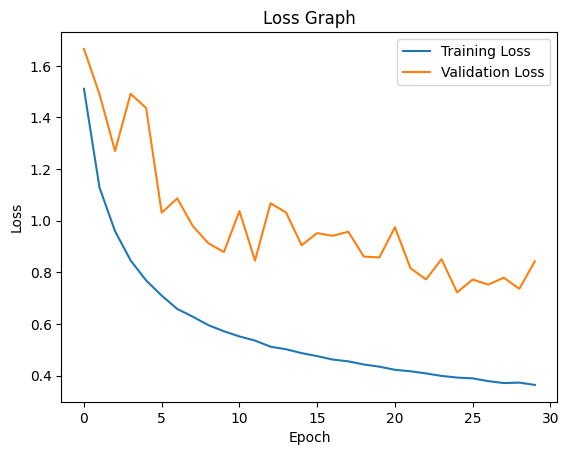

In [209]:
model = Resnet()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0003)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
  model.train()
  running_loss = 0
  for i, (images, labels) in enumerate(tqdm(train_loader)):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    predictions = model(images)
    loss = criterion(predictions, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  train_losses.append(running_loss/len(train_loader))

  print(f'Epoch: {epoch+1}/{num_epochs} | Training Loss: {running_loss/len(train_loader)}')

  model.eval()
  running_loss = 0
  with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader):
      images, labels = images.to(device), labels.to(device)

      predictions = model(images)
      loss = criterion(predictions, labels)
      running_loss += loss.item()

  scheduler.step(running_loss/len(val_loader))
  val_losses.append(running_loss/len(val_loader))

  print(f'Epoch: {epoch+1}/{num_epochs} | Valid Loss: {running_loss/len(val_loader)}')

plt.title('Loss Graph')
sns.lineplot(train_losses, label='Training Loss')
sns.lineplot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [210]:
all_predictions = []
all_labels = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Compute model predictions
        predictions = model(images)
        predictions = torch.argmax(predictions, dim=1)

        # Append predictions and labels to lists
        all_predictions.extend(predictions.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluation Metrics
accuracy = accuracy_score(all_labels, all_predictions)
print(f'Accuracy on test set: {accuracy}')

Accuracy on test set: 0.7345
